# IEEE Fraud Detect: part 03:
## Trying out Machine learning models

In [50]:
import os
import gc
gc.enable()
import time

import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore")

In [51]:
# Loading the normalized reduced dataset for training
train_data = pd.read_parquet(os.getcwd() + '\\pca_num_train.gzip')
target = pd.read_parquet(os.getcwd() + '\\target_var.gzip')

In [52]:
# Only load for prediction or later for manipulaiton:
# test_data = pd.read_parquet(os.getcwd() + '\\Data\\test.gzip')

# Testing out Random Forest Classification: on imbalanced dataset

Sources:
- https://github.com/WillKoehrsen/Machine-Learning-Projects/blob/master/Random%20Forest%20Tutorial.ipynb

In [53]:
# Split into 70% training and 30% validation set. Taking a bit more in validation set as data is highly imbalanced.
from sklearn.model_selection import train_test_split

X, X_val, y, y_val = train_test_split(train_data, target, 
                                        test_size = 0.3, 
                                        random_state = 10)

In [54]:
from sklearn.ensemble import RandomForestClassifier

RSEED = 100 # defining random seed for reproducibility

# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=10, 
                               random_state=RSEED, 
                               max_features = 'auto',
                               verbose = 1) # n_jobs=-1 # means using all processors for parallel use

# Fit on training data
model.fit(X.values, y.values)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   36.9s finished


RandomForestClassifier(n_estimators=10, random_state=100, verbose=1)

In [55]:
# We can see how many nodes there are for each tree on average and the maximum depth of each tree. There were 10 trees in the forest.

n_nodes = []
max_depths = []

for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 21247
Average maximum depth 61


In [56]:
# Random forest results

train_rf_predictions = model.predict(X.values)
train_rf_probs = model.predict_proba(X.values)[:, 1]

rf_predictions = model.predict(X_val.values)
rf_probs = model.predict_proba(X_val.values)[:, 1]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished


In [57]:

def evaluate_model(predictions, probs, train_predictions, train_probs, test_labels, train_labels):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
    baseline = {}
    
    baseline['recall'] = recall_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');

Recall Baseline: 1.0 Test: 0.36 Train: 0.86
Precision Baseline: 0.04 Test: 0.84 Train: 1.0
Roc Baseline: 0.5 Test: 0.84 Train: 1.0


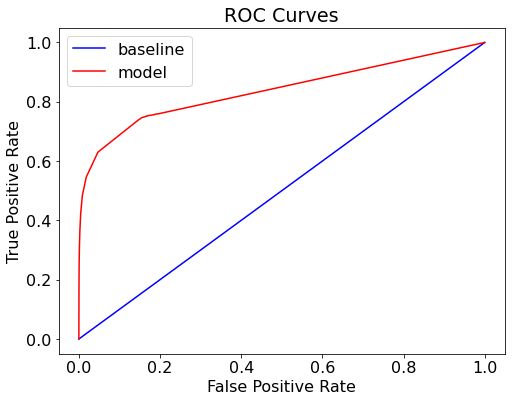

In [58]:
evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs, y_val, y)

In [59]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

Confusion matrix, without normalization
[[170439    423]
 [  4003   2297]]


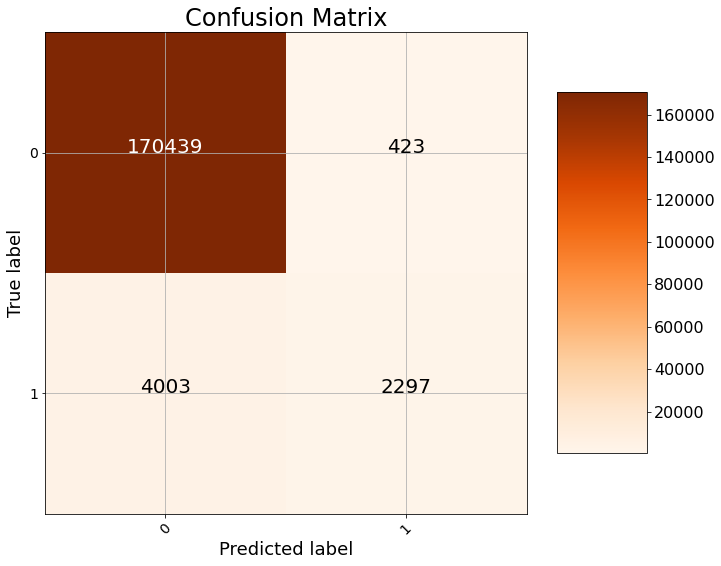

In [60]:
# confusion matrix for Validation set
cm = confusion_matrix(y_val, rf_predictions)
plot_confusion_matrix(cm, classes = ['0', '1'],
                      title = 'Confusion Matrix')

In [68]:
features = list(X.columns)
fi_model = pd.DataFrame({'feature': features,
                   'importance': model.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi_model.head(10)

,feature,importance
8,C_num_pca1,0.092624
9,C_num_pca2,0.076902
7,C_num_pca0,0.041788
0,rem_num_pca0,0.038579
1,rem_num_pca1,0.035152
2,rem_num_pca2,0.033303
11,D_num_pca1,0.028075
14,D_num_pca4,0.026198
33,V_num_pca12,0.024407
30,V_num_pca9,0.022971
